In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

We will return to the iris dataset.

In [2]:
iris = pd.read_csv("iris.csv", header = None)
iris = iris.rename(columns = {
    0: "sepal_length", 
    1: "sepal_width", 
    2: "petal_length", 
    3: "petal_width", 
    4: "type"
})

# Here are 3 items from the dataset.
iris.loc[[0, 60, 120]]

cov = np.array(iris.drop('type', axis = 1))
resp, _ = pd.factorize(iris["type"])

cov[:5, :]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [3]:
iris

,sepal_length,sepal_width,petal_length,petal_width,type
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Lets do a scatter plot of these just with respect to two variables

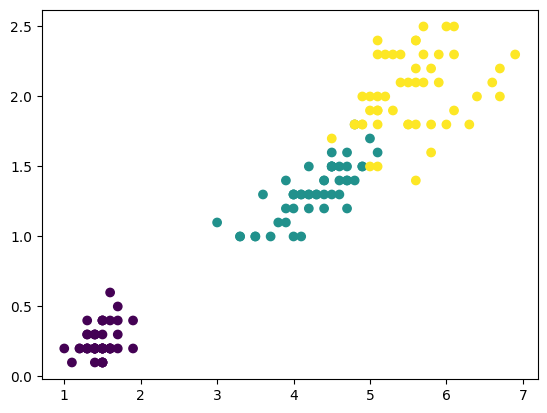

In [147]:
plt.scatter(x = cov[:, 2], y = cov[:, 3], c = resp)

The classes are not too badly separated, but lets see what PCA gives us.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA

In [8]:
scaler = StandardScaler().fit(cov)

Let us extract the top 2 principal components.

In [9]:
pca = PCA(n_components = 2).fit(scaler.transform(cov))
pca.components_

array([[ 0.52237162, -0.26335492,  0.58125401,  0.56561105],
       [ 0.37231836,  0.92555649,  0.02109478,  0.06541577]])

Each row is a projecting vector $\phi_i$. So, they should be orthogonal and have unit norm. Let us check both these at once, by computing:

In [10]:
Phi = np.matrix(pca.components_)
Phi @ Phi.T

matrix([[ 1.00000000e+00, -2.01263195e-16],
        [-2.01263195e-16,  1.00000000e+00]])

The diagonal entries are 1, and the off diagonal entries are 0, which is exactly what we expect. Let us see how the dataset looks through the lens of these components. First lets see what the top component gives us:

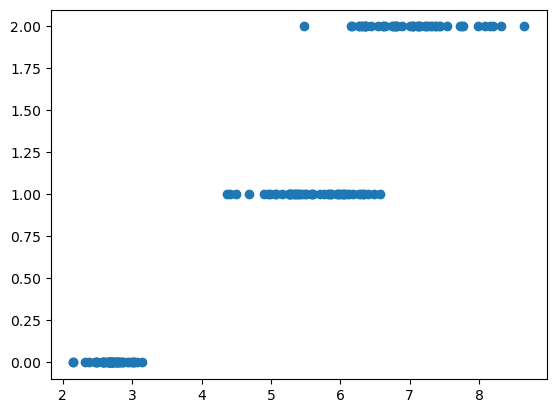

In [11]:
reduced = pca.transform(cov)
plt.scatter(x = reduced[:, 0], y = resp)

Not bad for a single real variable. Observe that the second component is quite bad in comparison.

In [13]:
len(reduced)

150

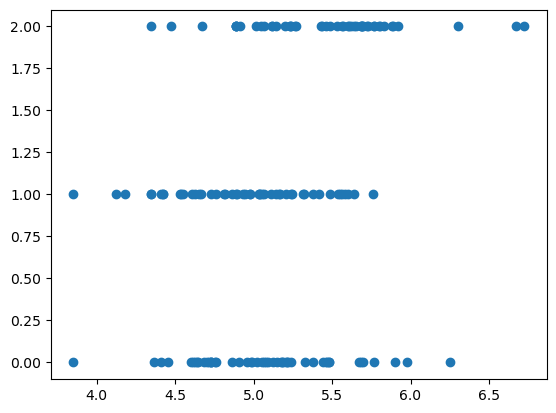

In [14]:
plt.scatter(x = reduced[:, 1], y = resp)

That's because it explains the _residual variance_. Now lets see both at once.

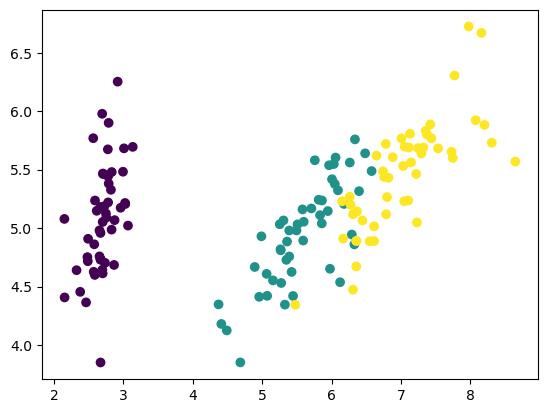

In [15]:
plt.scatter(x = reduced[:, 0], y = reduced[:, 1], c = resp)

To see how KernelPCA is an improvement, let us use the abalone dataset:

In [17]:
df = pd.read_csv("abalone.csv", header = None)
df = df.rename(columns = {
    0: "sex",
    1: "length",
    2: "diameter",
    3: "height",
    4: "whole_weight",
    5: "s_weight",
    6: "v_weight",
    7: "shell_weight",
    8: "rings"
})

# I will drop sex too since its a categorical variable
cov = np.array(df.drop(["rings", "sex"], axis = 1))
resp = df["rings"]

In [18]:
scaler = StandardScaler().fit(cov)
covt = scaler.transform(cov)

As a check, lets see how PCA performs:

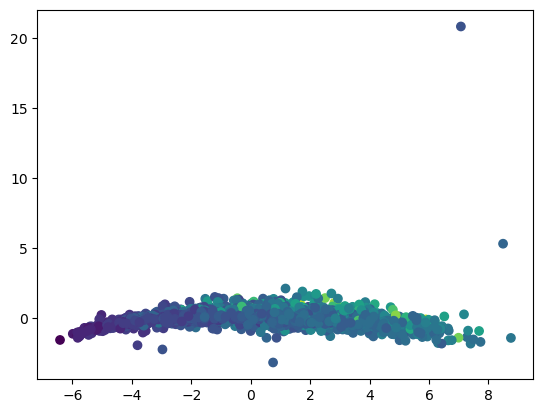

In [19]:
pca = PCA(n_components = 2).fit(covt)
reduced = pca.transform(covt)
plt.scatter(x = reduced[:, 0], y = reduced[:, 1], c = resp)

With the exception of some outliers, this is a good covariate. Let us compute its correlation of the top component with our target variable.

In [197]:
np.corrcoef(reduced[:, 0], resp)

array([[ 1.        , -0.48384558],
       [-0.48384558,  1.        ]])

... $\approx -0.48$ which is quite good.

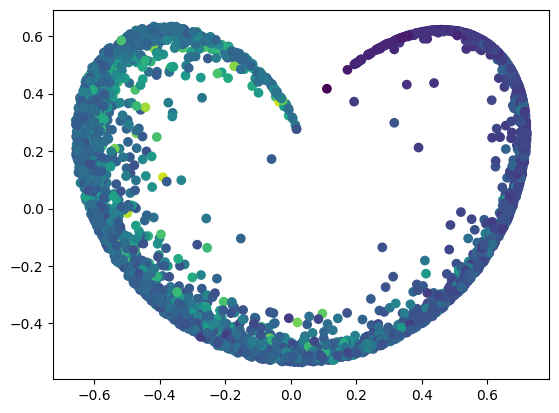

In [200]:
pca = KernelPCA(n_components = 2, kernel = 'rbf').fit(covt)
reduced = pca.transform(covt)
plt.scatter(x = reduced[:, 0], y = reduced[:, 1], c = resp)

In [201]:
np.corrcoef(reduced[:, 0], resp)

array([[ 1.        , -0.47403538],
       [-0.47403538,  1.        ]])

Approximately the same as earlier.

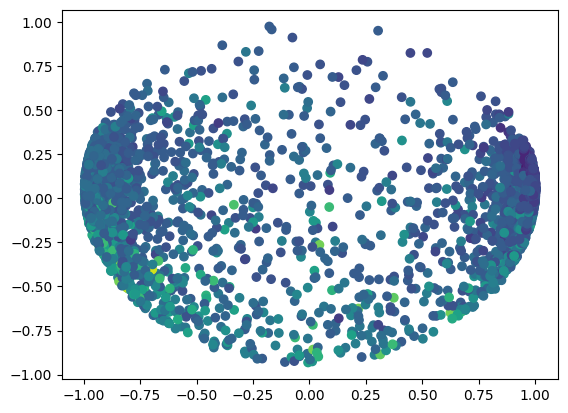

In [202]:
pca = KernelPCA(n_components = 2, kernel = 'cosine').fit(covt)
reduced = pca.transform(covt)
plt.scatter(x = reduced[:, 0], y = reduced[:, 1], c = resp)

In [203]:
np.corrcoef(reduced[:, 0], resp)

array([[ 1.        , -0.48384558],
       [-0.48384558,  1.        ]])

Which is also approximately the same. To see an example where kernels might help, let us use an artificial dataset with a nonlinear gap.

In [1]:
import numpy.random as npr
from sklearn.preprocessing import normalize

rng = npr.default_rng(seed = 5)

X = rng.normal(size = (1000, 2))
X[:500] += normalize(X[:500]) * 4

y = X[:, 0] ** 2 + X[:, 1] ** 2 # let the prediction be the squared norm

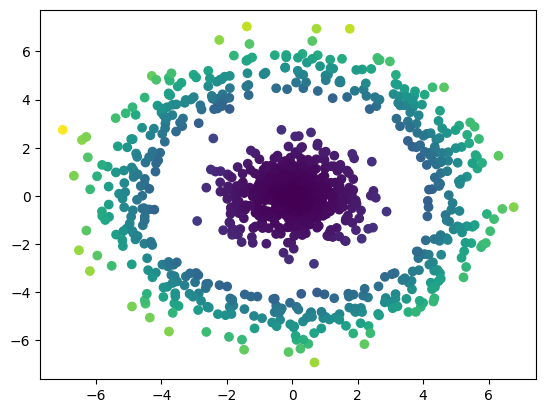

In [249]:
plt.scatter(X[:, 0], X[:, 1], c = y)

Let's apply PCA here.

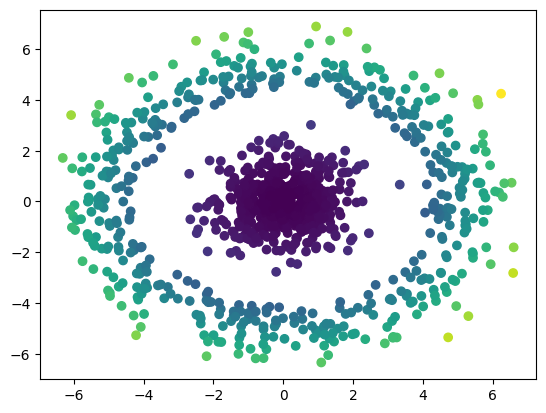

In [250]:
pca = PCA(n_components = 2).fit(X)
reduced = pca.transform(X)
plt.scatter(x = reduced[:, 0], y = reduced[:, 1], c = y)

In [251]:
np.corrcoef(reduced[:, 0], y)

array([[1.        , 0.00612415],
       [0.00612415, 1.        ]])

... a correlation of $\approx 0.06$, not useful.

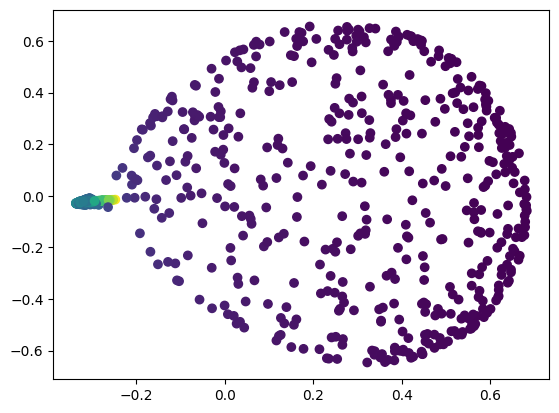

In [255]:
pca = KernelPCA(n_components = 2, kernel = 'rbf').fit(X)
reduced = pca.transform(X)
plt.scatter(x = reduced[:, 0], y = reduced[:, 1], c = y)

In [256]:
np.corrcoef(reduced[:, 0], y)

array([[ 1.        , -0.83523236],
       [-0.83523236,  1.        ]])

... a correlation of $\approx -0.835$, a significant improvement. This is because the radial basis functions can discriminate on radial values really well.